# 最尤推定

尤度を最大化するパラメータを求める．  
あるパラメータ$\theta$に従う確率分布からデータ$x$が得られる確率$P(x|\theta)$を最大化する$\theta$を求める．  

$$
\argmax_{\theta} \, P(x|\theta)
$$

In [2]:
import torch
import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt
import random


---

## 総当たりで求める

$\theta$の値を全て試して求める．

参考
- [最尤推定量とは？初めての人にもわかる解説 | AVILEN AI Trend](https://ai-trend.jp/basic-study/estimator/maximum-likelihood-estimation/)

<br>

以下の問題を例題として考える

> 箱の中に10個の玉がある．玉の色は赤か白のいずれかである．  
箱の中からランダムに玉を取り出し，色を確認してから戻す．これを10回繰り返した．  
その結果，赤玉が3回，白玉が7回出てきた．さあ，箱の中には赤玉が何個あるだろうか．

では解いていく．

$x$を赤が出た回数とすると，$x$は二項分布に従う．二項分布の確率密度関数は以下．  

$$
\mathrm{bin}(x; n, p) = {}_n C_x p^x (1-p)^{n-x}
$$


二項分布のパラメータは試行回数$n$と確率$p$で，今回の場合$n=10$が確定しており，$p$が推定したいパラメータとなる．  
$p$は箱の中に入っている赤玉の割合を表すので，これに$n=10$をかければ赤玉の数が推定できる．

<br>

最尤推定ではまず尤度関数を設定する．これは，あるパラメータ$\theta$の下であるデータ$x$が得られる確率を返す，$\theta$についての関数である．  
今回の場合は以下の様になる．

$$
\mathrm{L}(\theta|x) = \mathrm{bin}(x; n, \theta) = {}_n C_x \theta^x (1-\theta)^{n-x}
$$

すると，最尤推定で求めたいものは以下の様に表せる．

$$
\argmax_{\theta} \, \mathrm{L}(\theta|x)
$$

これを総当たりで求める．この問題において，$\theta$は以下の11通りである．

In [3]:
theta = torch.arange(0, 10 + 1) / 10
theta

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000])

これら一つ一つで尤度を計算して，最大値を取った$\theta$を求める．

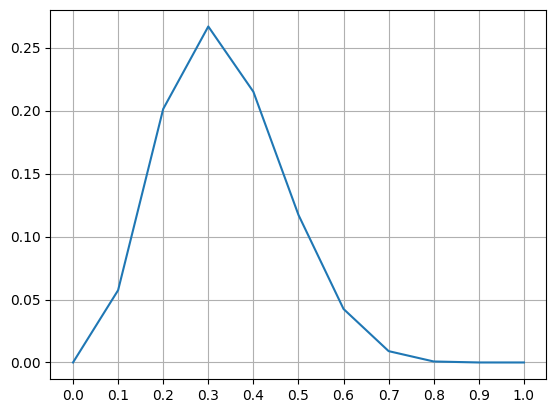

In [4]:
x = torch.tensor(3) # 実測値
n = 10 # 試行回数

binomal = dist.Binomial(n, theta) # 試行回数10, 確率psの二項分布
probs = binomal.log_prob(x).exp() # 分布から3が得られる確率
plt.plot(theta, probs)
plt.xticks(theta)
plt.grid();

$\theta = 0.3$が最も大きくなった．この$\theta$は**最尤推定量**と呼ぶ．  
以上より，箱の中には赤玉が$n \times \theta = 3$個あると推定できる．


---

## 解析的に求める

先ほどは$\theta$が離散値で且つ選択肢も少なかったので総当たりで求められたが，選択肢が多い場合やそもそも連続値の場合，総当たりには限界がある．  
そこで，解析的に（計算で）求める手法を考える．

やり方は簡単で，尤度関数を$\theta$について微分して，傾きが0になる$\theta$を求めるだけ．

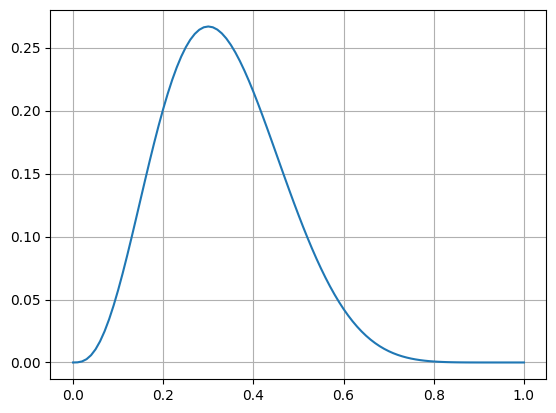

In [5]:
p = torch.arange(0, 1 + 0.01, 0.01)
binomal = dist.Binomial(10, p)
log_likelihood = binomal.log_prob(x) # 対数尤度
likelihood = log_likelihood.exp() # 尤度
plt.plot(p, likelihood)
plt.grid();

これを微分する．

ここで

$$
L(\theta|x) = {}_n C_x \theta^x (1-\theta)^{n-x}
$$

は微分が面倒臭い．そこで，対数をとった関数

$$
\log \, L(\theta|x)
$$

を考える．

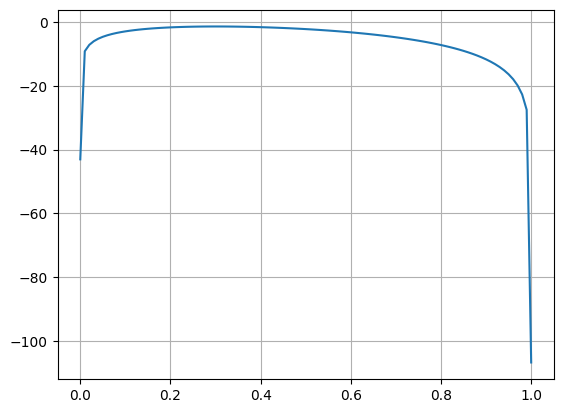

In [6]:
plt.plot(p, log_likelihood)
plt.grid();

こうすると微分が簡単になる．これは対数尤度関数と呼ぶ．  
$\argmax_x x = \argmax_x \log x$が成り立つので，対数尤度関数を最大化する$\theta$を求めればよい．


<br>

実際に計算してみる．まず対数尤度関数を変形する．

$$
\begin{align}
    \mathrm{log} \, L(\theta|x)
        &= \mathrm{log} \, \left( {}_n C_x \theta^x (1-\theta)^{n-x} \right) \\
        &= \mathrm{log} \, {}_n C_x + x \mathrm{log} \, \theta + (n-x) \mathrm{log} \, (1-\theta) \\ 
\end{align}
$$

次にこれを$\theta$で微分する

$$
\begin{align}
    \frac{\mathrm{d}}{\mathrm{d} \theta} \mathrm{log} \, L(\theta|x)
        &= 0 + \frac{x}{\theta} - \frac{n-x}{1-\theta} \\
        &= \frac{x(1-\theta) - (n-x)\theta}{\theta(1-\theta)} \\
        &= \frac{x - \theta n}{\theta(1-\theta)} \\
\end{align}
$$

最後にこれが0になる$\theta$を求める

$$
\begin{align}
    \frac{x - \theta n}{\theta(1-\theta)} &= 0 \\
    x - \theta n &= 0 \\
    \theta n &= x \\
    \theta &= \frac{x}{n} \\
\end{align}
$$

$n=10, x=3$より，$\theta = \frac{3}{10} = 0.3$が最尤推定量となる．


---

## EMアルゴリズム

解析的な求め方ができない場合に役立つ手法．

<br>

先ほどの問題は二項分布という簡単な分布を用いたが，複雑な分布だと解析的に求めることも難しくなる．

例えば，以下の分布を考える．

$$
z \sim \mathrm{Bernoulli}(\theta) \\
x \sim \begin{cases}
    \mathrm{Normal}(0, 1) & (z=0) \\
    \mathrm{Normal}(5, 1) & (z=1)
\end{cases}
$$

$\theta$を0.7にしてサンプリングしてみる．

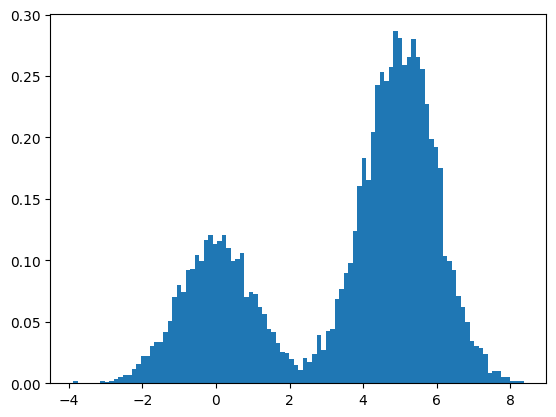

In [7]:
theta = 0.7
n = 10000

ber = dist.Bernoulli(theta)
norm0 = dist.Normal(0, 1)
norm1 = dist.Normal(5, 1)
def sampling(n):
    x = []
    for _ in range(n):
        z = ber.sample()
        if z == 0:
            x.append(norm0.sample())
        else:
            x.append(norm1.sample())
    return torch.tensor(x)

x = sampling(n)
plt.hist(x, bins=100, density=True);

このデータから$\theta$を予測する．

参考
- [EMアルゴリズムとともだちになろう | ドクセル](https://www.docswell.com/s/mutopsy/K18DP5-2022-08-16-163818#p17)
- [【徹底解説】EMアルゴリズムをはじめからていねいに | Academaid](https://academ-aid.com/ml/em)

まず尤度関数を考える．

$$
\mathrm{L}(\theta|x) = \prod_{i=1}^n p(x_i; \theta)
$$

次に対数尤度関数を考える．

$$
\begin{align}
    \mathrm{log} \, L(\theta|x)
        &= \mathrm{log} \, \prod_{i=1}^n p(x_i; \theta) \\
        &= \sum_{i=1}^n \log \, p(x_i; \theta) \\
\end{align}
$$

ここで，$p(x_i; \theta)$を周辺化する．

$$
p(x_i; \theta) = \sum_{j=0}^1 p(x_i, z_j; \theta)
$$

でこれを対数尤度関数に当てはめると

$$
\mathrm{log} \, L(\theta|x) = \sum_{i=1}^n \log \, \sum_{j=0}^1 p(x_i, z_j; \theta)
$$

$\log$の中に$\Sigma$が入ってしまった．これは計算が困難．

<br>

この様に，**潜在変数**が絡む分布の場合は$\log$の中に$\Sigma$が入ってしまって計算が困難になる．  
潜在変数とは，観測できない（表面に出てこない）が分布に影響を与える変数のこと．上の式でいうと$z$がそれに当たる．  
潜在変数が絡む分布の代表的な例は混合ガウス分布．こういった分布は尤度を潜在変数で周辺化することで$\log$の中に$\Sigma$が入るため，最尤推定が解析的に行えない．

そんな時に使うのがEMアルゴリズム．

まず周辺対数尤度をグラフにしてみる．

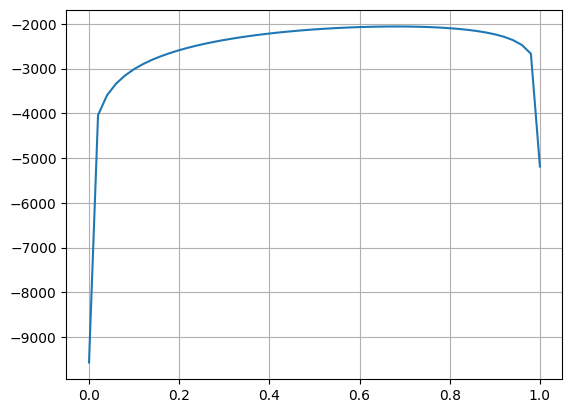

In [8]:
x = sampling(1000)
ps = torch.arange(0, 1 + 0.02, 0.02)

def log_likelihood(x, p):
    ber = dist.Bernoulli(p)
    ll = 0
    for xi in x:
        ll_ = 0
        ll_ += ber.log_prob(torch.tensor(0.)).exp() * norm0.log_prob(xi).exp()
        ll_ += ber.log_prob(torch.tensor(1.)).exp() * norm1.log_prob(xi).exp()
        ll += torch.log(ll_)
    return ll

lls = [log_likelihood(x, p) for p in ps]
plt.plot(ps, lls)
plt.grid();

こんな感じ．最大値も0.7を示してる．

In [9]:
idx = torch.argmax(torch.tensor(lls))
ps[idx]

tensor(0.6800)

（総当たりで求められるじゃんって思うかもしれないけど，$\theta$を0.02刻みで離散化して，サンプル数を1000に減らした上でこの計算時間なので，実用的では無い．）

では式変形をしていこう．  
まず**イェンゼンの不等式**を使って，対数尤度関数の下界を求める．

$$
\begin{align}
    \log L(\theta|x)
        &= \sum_{i=1}^n \log \sum_{j=0}^1 p(x_i, z_j; \theta) \\
        &= \sum_{i=1}^n \log \sum_{j=0}^1 \lambda_{ij} \frac{p(x_i, z_j; \theta)}{\lambda_{ij}} \quad \\
        &\geq \sum_{i=1}^n \sum_{j=0}^1 \lambda_{ij} \log \frac{p(x_i, z_j; \theta)}{\lambda_{ij}} \\
        &= \mathcal{L}(\theta|\lambda)
\end{align}
$$

$\lambda_{ij}$は$\sum_{j=0}^1 \lambda_{ij} = 1$を満たすなんらかの実数．$\mathcal{L}(\theta|\lambda)$が下界．

<br>

ここで，対数尤度関数と下界の差を求める．

$$
\log L(\theta|x) - \mathcal{L}(\theta|\lambda) = \mathrm{KL}[\lambda||p(z|x, \theta)]
$$

$\lambda$と$p(z|x, \theta)$のKLダイバージェンスになる．途中式は省略．これを以下のようにまとめる．

$$
\log L(\theta|x) = \mathrm{KL}[\lambda||p(z|x, \theta)] + \mathcal{L}(\theta|\lambda)
$$

対数尤度関数をKLダイバージェンスと下界の和で表すことが出来た．これを最大化することを考える．

以下を繰り返すことで，対数尤度関数を最大化する．

- $\theta$を固定し，KLダイバージェンスを最小化する（=0にする）$\lambda$を求める
- $\lambda$を固定し，下界を最大化する$\theta$を求める

このとき，$\theta$は更新するたびに対数尤度を大きくすることが証明されているらしい  
初めは$\theta$か$\lambda$のどちらかを乱数かなんかで初期化する必要がある．どちらでもいいみたいだが，$\theta$を初めに初期化するのが一般的．

では初めに$\theta$を固定し，KLダイバージェンスを最小化する$\lambda$を求める．  
これは簡単で，KLダイバージェンスは二つの分布が完全に一致する場合のみ0をとるので，$\lambda = p(z|x, \theta)$とすれば良い．もうちょい細かく書くと，$\lambda_{ij} = p(z_{ij}|x_i, \theta)$とする．これはベイズの定理を使った変換によって求める事が可能．

$$
\lambda_{ij} = p(z_{ij}|x_i, \theta) = \frac{p(x_i|z_j;\theta)p(z_{ij})}{p(x_i|z_{i0};\theta)p(z_{i0}) + p(x_i|z_{i1};\theta)p(z_{i1})}
$$

In [21]:
def kl_minimze(X, theta):
    n_samples = len(X)
    lmd = torch.zeros(n_samples, 2)
    for i, x in enumerate(X):
        l_0 = norm0.log_prob(x).exp() * (1 - theta)
        l_1 = norm1.log_prob(x).exp() * theta
        l = l_0 + l_1
        lmd[i, 0] = l_0 / l
        lmd[i, 1] = l_1 / l
    return lmd

次は$\lambda$を固定し，下界を最大化する$\theta$を求める．  
まず下界$\mathcal{L}(\theta|\lambda)$を変形する．前のステップで定めた$\theta$を$\theta_{old}$としておく

$$
\begin{align}
    \mathcal{L}(\theta|\lambda)
        &= \sum_{i=1}^n \sum_{j=0}^1 \lambda_j \log \, \frac{p(x_i, z_j; \theta)}{\lambda_j} \\
        &= \sum_{i=1}^n \sum_{j=0}^1 p(z_j|x_i; \theta_{old}) \log \frac{p(x_i, z_j; \theta)}{p(z_j|x_i; \theta_{old})} \\
        &= \sum_{i=1}^n \sum_{j=0}^1 p(z_j|x_i; \theta_{old}) \, \log p(x_i, z_j; \theta) + \mathrm{const} \\
        &= \mathcal{Q}(\theta|\theta_{old}) + \mathrm{const}
\end{align}
$$

$z$の事後分布の対数尤度に関する期待値になった．この期待値を求める過程を**Eステップ**と呼ぶ（期待値=*Expected Value*）．

次に，新たな$\theta$として，この下界を最大にする$\theta$を求める．

$$
\begin{align}
    \theta_{new}
        &= \argmax_\theta \, \mathcal{L}(\theta|\lambda) \\
        &= \argmax_\theta \, \mathcal{Q}(\theta|\theta_{old}) \\
        &= \argmax_\theta \, \sum_{i=1}^n \sum_{j=0}^1 p(z_j|x_i; \theta_{old}) \log p(x_i, z_j; \theta) \\
\end{align}
$$

これは微分すれば簡単に求められる．

この時，$\log L(\theta_{new}) \ge \log L(\theta_{old})$が保証されるらしい．この下界を最大化する過程を**Mステップ**と呼ぶ（最大化=*Maximum*）．

EステップとMステップを繰り返すことから，EMアルゴリズムと呼ばれる．